In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

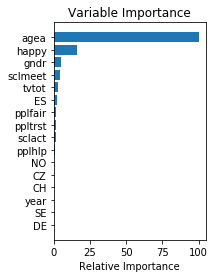

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

In [6]:
df.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,4.022622e+04,6.500307,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,1.496379,47.262182,1.384681
std,6.320721e+05,0.500031,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,0.500018,18.316890,0.486550
min,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,1.000000
25%,1.063000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,1.000000
50%,1.749000e+03,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,1.000000
75%,2.778000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,2.000000
max,1.100143e+07,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,2.000000


### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [12]:
import itertools
n_estimators = [100, 250, 500, 750, 1000]
max_depth = [2, 3, 5, 8, 10]
loss = ['deviance', 'exponential']
subsample = [0.3, 0.5, 0.8, 0.9, 1.0]

lists = [n_estimators, max_depth, loss, subsample]

param_dict = pd.DataFrame(list(itertools.product(*lists)), 
                          columns=['n_estimators', 'max_depth', 'loss', 'subsample']).to_dict(orient='records')

In [14]:
for params in param_dict:
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)

    table_test = pd.crosstab(y_test, predict_test, margins=True)

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        '---Parameters--- {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(params, test_tI_errors, test_tII_errors))
    params['typeI'] = test_tI_errors
    params['typeII'] = test_tII_errors

---Parameters--- {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.19754601226993865
---Parameters--- {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.2049079754601227
---Parameters--- {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.05521472392638037
Percent Type II errors: 0.2049079754601227
---Parameters--- {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.20245398773006135
---Parameters--- {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.05030674846625767
Percent Type II errors: 0.2085889570552147
---

---Parameters--- {'n_estimators': 100, 'max_depth': 10, 'loss': 'deviance', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.09570552147239264
Percent Type II errors: 0.18282208588957055
---Parameters--- {'n_estimators': 100, 'max_depth': 10, 'loss': 'deviance', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.09325153374233129
Percent Type II errors: 0.17791411042944785
---Parameters--- {'n_estimators': 100, 'max_depth': 10, 'loss': 'deviance', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.1067484662576687
Percent Type II errors: 0.18650306748466258
---Parameters--- {'n_estimators': 100, 'max_depth': 10, 'loss': 'deviance', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.10797546012269939
Percent Type II errors: 0.17177914110429449
---Parameters--- {'n_estimators': 100, 'max_depth': 10, 'loss': 'exponential', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.10552147239263804
Percent Type II errors: 0.17546012269

---Parameters--- {'n_estimators': 250, 'max_depth': 8, 'loss': 'deviance', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.10552147239263804
Percent Type II errors: 0.1705521472392638
---Parameters--- {'n_estimators': 250, 'max_depth': 8, 'loss': 'deviance', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.11411042944785275
Percent Type II errors: 0.16441717791411042
---Parameters--- {'n_estimators': 250, 'max_depth': 8, 'loss': 'deviance', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.09938650306748466
Percent Type II errors: 0.18036809815950922
---Parameters--- {'n_estimators': 250, 'max_depth': 8, 'loss': 'exponential', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.11533742331288344
Percent Type II errors: 0.1656441717791411
---Parameters--- {'n_estimators': 250, 'max_depth': 8, 'loss': 'exponential', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.12024539877300613
Percent Type II errors: 0.17177914110429

---Parameters--- {'n_estimators': 500, 'max_depth': 5, 'loss': 'deviance', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.11042944785276074
Percent Type II errors: 0.1754601226993865
---Parameters--- {'n_estimators': 500, 'max_depth': 5, 'loss': 'deviance', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.10552147239263804
Percent Type II errors: 0.17423312883435582
---Parameters--- {'n_estimators': 500, 'max_depth': 5, 'loss': 'exponential', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.07116564417177915
Percent Type II errors: 0.18773006134969325
---Parameters--- {'n_estimators': 500, 'max_depth': 5, 'loss': 'exponential', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.1165644171779141
Percent Type II errors: 0.16319018404907976
---Parameters--- {'n_estimators': 500, 'max_depth': 5, 'loss': 'exponential', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.10184049079754601
Percent Type II errors: 0.17546012269

---Parameters--- {'n_estimators': 750, 'max_depth': 3, 'loss': 'deviance', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.08834355828220859
Percent Type II errors: 0.18650306748466258
---Parameters--- {'n_estimators': 750, 'max_depth': 3, 'loss': 'exponential', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.10184049079754601
Percent Type II errors: 0.16809815950920245
---Parameters--- {'n_estimators': 750, 'max_depth': 3, 'loss': 'exponential', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.08588957055214724
Percent Type II errors: 0.18159509202453988
---Parameters--- {'n_estimators': 750, 'max_depth': 3, 'loss': 'exponential', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.06748466257668712
Percent Type II errors: 0.1901840490797546
---Parameters--- {'n_estimators': 750, 'max_depth': 3, 'loss': 'exponential', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.18650306

---Parameters--- {'n_estimators': 1000, 'max_depth': 2, 'loss': 'exponential', 'subsample': 0.3}

Test set accuracy:
Percent Type I errors: 0.08588957055214724
Percent Type II errors: 0.16932515337423312
---Parameters--- {'n_estimators': 1000, 'max_depth': 2, 'loss': 'exponential', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.07607361963190185
Percent Type II errors: 0.18527607361963191
---Parameters--- {'n_estimators': 1000, 'max_depth': 2, 'loss': 'exponential', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.06993865030674846
Percent Type II errors: 0.18282208588957055
---Parameters--- {'n_estimators': 1000, 'max_depth': 2, 'loss': 'exponential', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.06993865030674846
Percent Type II errors: 0.19141104294478528
---Parameters--- {'n_estimators': 1000, 'max_depth': 2, 'loss': 'exponential', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.07239263803680981
Percent Type II errors: 

---Parameters--- {'n_estimators': 1000, 'max_depth': 10, 'loss': 'exponential', 'subsample': 0.5}

Test set accuracy:
Percent Type I errors: 0.10184049079754601
Percent Type II errors: 0.18036809815950922
---Parameters--- {'n_estimators': 1000, 'max_depth': 10, 'loss': 'exponential', 'subsample': 0.8}

Test set accuracy:
Percent Type I errors: 0.1067484662576687
Percent Type II errors: 0.18036809815950922
---Parameters--- {'n_estimators': 1000, 'max_depth': 10, 'loss': 'exponential', 'subsample': 0.9}

Test set accuracy:
Percent Type I errors: 0.10306748466257669
Percent Type II errors: 0.18404907975460122
---Parameters--- {'n_estimators': 1000, 'max_depth': 10, 'loss': 'exponential', 'subsample': 1.0}

Test set accuracy:
Percent Type I errors: 0.10306748466257669
Percent Type II errors: 0.18282208588957055


In [15]:
param_df = pd.DataFrame(param_dict, columns=['n_estimators', 'max_depth', 'loss', 'subsample', 'typeI', 'typeII'])
param_df.head()

,n_estimators,max_depth,loss,subsample,typeI,typeII
0,100,2,deviance,0.3,0.057669,0.197546
1,100,2,deviance,0.5,0.057669,0.204908
2,100,2,deviance,0.8,0.055215,0.204908
3,100,2,deviance,0.9,0.052761,0.202454
4,100,2,deviance,1.0,0.050307,0.208589


In [16]:
param_df['total_error'] = param_df['typeI'] +  param_df['typeII']
min_fp = param_df.sort_values('typeI')
min_fn = param_df.sort_values('typeII')
min_ttlerr = param_df.sort_values('total_error')
min_fp.head()

,n_estimators,max_depth,loss,subsample,typeI,typeII,total_error
9,100,2,exponential,1.0,0.050307,0.209816,0.260123
4,100,2,deviance,1.0,0.050307,0.208589,0.258896
5,100,2,exponential,0.3,0.050307,0.207362,0.257669
3,100,2,deviance,0.9,0.052761,0.202454,0.255215
8,100,2,exponential,0.9,0.052761,0.206135,0.258896


In [17]:
min_fn.head()

,n_estimators,max_depth,loss,subsample,typeI,typeII,total_error
120,500,5,deviance,0.3,0.125153,0.159509,0.284663
70,250,5,deviance,0.3,0.115337,0.160736,0.276074
230,1000,8,deviance,0.3,0.134969,0.160736,0.295706
223,1000,5,deviance,0.9,0.123926,0.163190,0.287117
126,500,5,exponential,0.5,0.116564,0.163190,0.279755


In [20]:
min_ttlerr.head(30)

,n_estimators,max_depth,loss,subsample,typeI,typeII,total_error
58,250,2,exponential,0.9,0.053988,0.188957,0.242945
53,250,2,deviance,0.9,0.057669,0.186503,0.244172
54,250,2,deviance,1.0,0.053988,0.191411,0.245399
106,500,2,exponential,0.5,0.060123,0.185276,0.245399
18,100,3,exponential,0.9,0.053988,0.192638,0.246626
14,100,3,deviance,1.0,0.055215,0.191411,0.246626
12,100,3,deviance,0.8,0.060123,0.186503,0.246626
57,250,2,exponential,0.8,0.058896,0.188957,0.247853
59,250,2,exponential,1.0,0.053988,0.193865,0.247853
154,750,2,deviance,1.0,0.067485,0.180368,0.247853


If I were interested in just the model with the lowest total error, I would take the parameters 250 estimators, 0.9 subsample, 2 deep exponential loss. There is some imbalance in the outcome space toward the negative outcome (mean 1.38 with outcomes 1 or 2). This may be the reason for higher type II error (false negatives). For this reason, I will choose the parameters that give a relatively low type II error while retaining good overall accuracy:

- n_estimators:  500
- max_depth:       3
- loss:     deviance
- subsample:     0.3

